In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

In [2]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[strip(a) for a in split(feature_text,',')]
print len(features),features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [3]:
# create a directory called higgs, download and decompress HIGGS.csv.gz into it

from os.path import exists
if not exists('higgs'):
    print "creating directory higgs"
    !mkdir higgs
%cd higgs
if not exists('HIGGS.csv'):
    if not exists('HIGGS.csv.gz'):
        print 'downloading HIGGS.csv.gz'
        !curl -O http://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
    print 'decompressing HIGGS.csv.gz --- May take 5-10 minutes'
    !gunzip -f HIGGS.csv.gz
!ls -l
%cd ..

creating directory higgs
/Users/gaoyue/Desktop/CSE_255/homework/HW5/higgs
downloading HIGGS.csv.gz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2685M  100 2685M    0     0  7440k      0  0:06:09  0:06:09 --:--:-- 9832k
decompressing HIGGS.csv.gz --- May take 5-10 minutes
total 15694336
-rw-r--r--  1 gaoyue  staff  8035497980  5 16 20:59 HIGGS.csv
/Users/gaoyue/Desktop/CSE_255/homework/HW5


In [7]:
# Have a look at the first two lines of the data file
!head -1 higgs/higgs.csv

1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01


In [8]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='higgs/higgs.csv'
inputRDD=sc.textFile(path)
inputRDD.first()

u'1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01'

In [20]:
# Transform the text RDD into an RDD of LabeledPoints
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
    .map(lambda x:LabeledPoint(x[0],x[1:]))
Data.first()

LabeledPoint(1.0, [0.869293212891,-0.635081827641,0.22569026053,0.327470064163,-0.689993202686,0.754202246666,-0.24857313931,-1.09206390381,0.0,1.37499213219,-0.653674185276,0.930349111557,1.10743606091,1.13890433311,-1.57819831371,-1.0469853878,0.0,0.65792953968,-0.0104545699432,-0.0457671694458,3.10196137428,1.35376000404,0.979563117027,0.978076159954,0.920004844666,0.721657454967,0.988750934601,0.876678347588])

In [21]:
Data1=Data.sample(False,0.01).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

print 'Sizes: Data1=%d, trainingData=%d, testData=%d'%(Data1.count(),trainingData.cache().count(),testData.cache().count())

Sizes: Data1=109509, trainingData=76655, testData=32854


In [22]:
import pickle

In [24]:
f = open('sampledata.data','wb')
pickle.dump(Data1.collect(),f)

In [28]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(1.0, 17358), (0.0, 15496)]

In [29]:
from time import time
errors={}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo={},numIterations=10,
                                               maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.3693309794849942, 'train': 0.3645815667601592} 142 seconds
3 {'test': 0.3323796189200706, 'train': 0.3238536299002022} 178 seconds
6 {'test': 0.3045900042612772, 'train': 0.2896875611506099} 234 seconds
10 {'test': 0.30559444816460707, 'train': 0.19508186028308655} 984 seconds
{1: {'test': 0.3693309794849942, 'train': 0.3645815667601592}, 10: {'test': 0.30559444816460707, 'train': 0.19508186028308655}, 3: {'test': 0.3323796189200706, 'train': 0.3238536299002022}, 6: {'test': 0.3045900042612772, 'train': 0.2896875611506099}}


In [30]:
B10 = errors

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


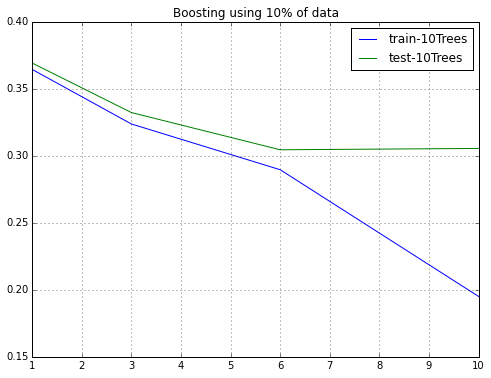

In [31]:
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

In [32]:
from time import time
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData,numClasses=2 ,categoricalFeaturesInfo={},
                                    numTrees=10, featureSubsetStrategy="auto",
                                    impurity='gini', maxDepth=depth, maxBins=32)

    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.43023680525963354, 'train': 0.4267040636618616} 34 seconds
3 {'test': 0.3871674681926097, 'train': 0.3781618942012915} 34 seconds
6 {'test': 0.33094904730017655, 'train': 0.32250994716587306} 69 seconds
10 {'test': 0.31149936080842516, 'train': 0.2635183614897919} 186 seconds
15 {'test': 0.31320387167468194, 'train': 0.13185049898897658} 497 seconds
20 {'test': 0.3221829914165703, 'train': 0.03091774835301024} 1159 seconds
{1: {'test': 0.43023680525963354, 'train': 0.4267040636618616}, 3: {'test': 0.3871674681926097, 'train': 0.3781618942012915}, 6: {'test': 0.33094904730017655, 'train': 0.32250994716587306}, 10: {'test': 0.31149936080842516, 'train': 0.2635183614897919}, 15: {'test': 0.31320387167468194, 'train': 0.13185049898897658}, 20: {'test': 0.3221829914165703, 'train': 0.03091774835301024}}


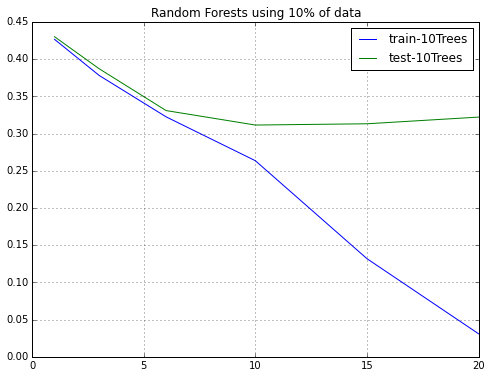

In [34]:
RF_10trees = errors
# Plot Train/test accuracy vs Depth of trees graph
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')